In [2]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_csv('../input/tabular-playground-series-jan-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-jan-2021/test.csv')
sub = pd.read_csv('../input/tabular-playground-series-jan-2021/sample_submission.csv')

train.head()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


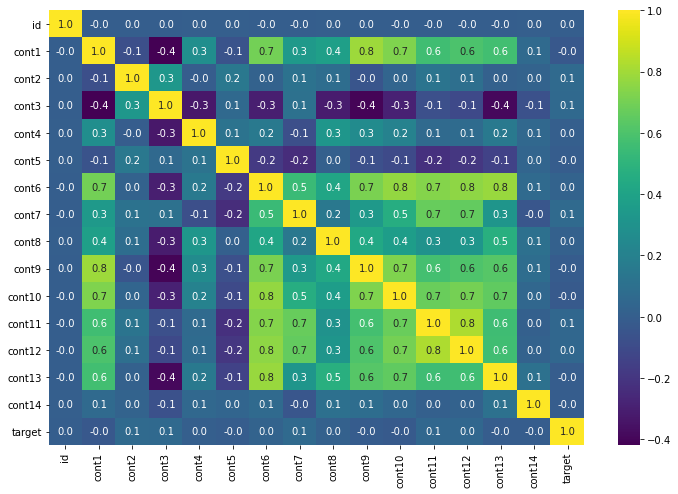

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True, fmt='.1f', cmap='viridis')
plt.show()

In [6]:
train.shape, test.shape

((300000, 16), (200000, 15))

In [4]:
feature_cols = list(train.columns.values[1:10])

In [5]:
feature_cols.append('cont14')
feature_cols

['cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont14']

In [6]:
X = train[feature_cols]
y = train['target']
tes = test[feature_cols]

print(X.shape, tes.shape)

(300000, 10) (200000, 10)


In [7]:
# modelling

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=201)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(240000, 10)
(60000, 10)
(240000,)
(60000,)


In [8]:
from sklearn.ensemble import GradientBoostingRegressor
grb = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, max_depth=5)


In [12]:
# grb.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=400)

In [13]:
!pip install catboost

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [14]:
from catboost import CatBoostRegressor
cb_model = CatBoostRegressor(iterations=5000,
                            learning_rate = 0.005,
                            depth=8,
                            eval_metric='RMSE',
                            random_seed=42,
                            bagging_temperature=0.4,
                            od_type='Iter',
                            metric_period=50,
                            od_wait=20)

cb_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=100)

In [9]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    import lightgbm as lgb
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 40,
        'learning_rate': 0.004,
        'bagging_fraction': 0.6,
        'feature_fraction': 0.3,
        'bagging_frequency': 3,
        'bagging_seed': 42, 
        'verbosity': -1,
        'seed': 42
    }
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 7000, valid_sets=[lgtrain, lgval],
                     early_stopping_rounds=200, verbose_eval=300,
                     evals_result=evals_result)
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    
    return pred_test_y, model, evals_result

In [10]:
# Training LGB
pred_test, model, evals_result = run_lgb(X_train, y_train, X_test, y_test, tes)
print('\nLightGBM Training Completed...')

Training until validation scores don't improve for 200 rounds
[300]	training's rmse: 0.720904	valid_1's rmse: 0.723875
[600]	training's rmse: 0.714502	valid_1's rmse: 0.718161
[900]	training's rmse: 0.710583	valid_1's rmse: 0.714953
[1200]	training's rmse: 0.707774	valid_1's rmse: 0.712883
[1500]	training's rmse: 0.705628	valid_1's rmse: 0.7115
[1800]	training's rmse: 0.703883	valid_1's rmse: 0.710508
[2100]	training's rmse: 0.70239	valid_1's rmse: 0.709766
[2400]	training's rmse: 0.701111	valid_1's rmse: 0.709233
[2700]	training's rmse: 0.699984	valid_1's rmse: 0.708848
[3000]	training's rmse: 0.698969	valid_1's rmse: 0.708564
[3300]	training's rmse: 0.697986	valid_1's rmse: 0.708317
[3600]	training's rmse: 0.697093	valid_1's rmse: 0.708135
[3900]	training's rmse: 0.696235	valid_1's rmse: 0.707965
[4200]	training's rmse: 0.69541	valid_1's rmse: 0.707834
[4500]	training's rmse: 0.694619	valid_1's rmse: 0.707729
[4800]	training's rmse: 0.69386	valid_1's rmse: 0.70764
[5100]	training's r

In [17]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    import xgboost as xgb
    params = {'objective': 'reg:squarederror',
             'eval_metric': 'rmse',
              'learning_rate': 0.002,
             'eta': 0.001,
             'max_depth': 9,
             'subsample': 0.6,
             'colsample_bytree':0.6,
             'alpha':0.001,
             'random_state':42,
             'silent':True}
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    model_xgb = xgb.train(params, tr_data, 7000, watchlist, maximize=False, early_stopping_rounds=200,
                         verbose_eval=300)
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)
    
    return xgb_pred_y, model_xgb

In [18]:
# Training XGB
pred_test_xgb, model_xgb = run_xgb(X_train, y_train, X_test, y_test, tes)
print('XGB Training Completed')

[15:32:34] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:7.42710	valid-rmse:7.42714
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[150]	train-rmse:5.52211	valid-rmse:5.52217
[300]	train-rmse:4.11850	valid-rmse:4.11864
[450]	train-rmse:3.08852	valid-rmse:3.08885
[600]	train-rmse:2.33776	valid-rmse:2.33854
[750]	train-rmse:1.79672	valid-rmse:1.79837
[900]	train-rmse:1.41378	valid-rmse:1.41674
[1050]	train-rmse:1.14983	valid-rmse:1.15452
[1200]	train-rmse:0.97420	valid-rmse:0.98094
[1350]	train-rmse:0.86181	valid-rmse:0.87072
[1500]	train-rmse:0.79247	valid-rmse:0.80356
[1650]	train-rmse:0.75080	valid-rmse:0.763

In [19]:
from sklearn.metrics import mean_squared_error
pred = model_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print("RMSE:: ",rmse)

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [20]:
# submission file
sub['target'] = pred_test_xgb

sub.to_csv('baseline_xgb_model4.csv', index=False)